## ddqc Tutotial

In [1]:
import numpy as np
import pegasus as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Reading the data
For this tutotial we are going to be using count matrix dataset on Human Bone Marrow provided by pegasus.
You can download it at https://storage.googleapis.com/terra-featured-workspaces/Cumulus/MantonBM_nonmix_subset.zarr.zip. <br>

We will load the data using the standart `read_input` pegasus function.

In [2]:
data = pg.read_input("/Users/michaelalperovich/Downloads/MantonBM_nonmix_subset.zarr.zip")
data

2021-03-31 19:08:28,306 - pegasusio.readwrite - INFO - zarr file '/Users/michaelalperovich/Downloads/MantonBM_nonmix_subset.zarr.zip' is loaded.
2021-03-31 19:08:28,307 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.22s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 48219 x 36601
    Genome: GRCh38; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'Channel'
    var: 'featureid'
    obsm: 
    varm: 
    uns: 'genome', 'modality'

### Filtering step
ddqc does adaptive quality control by clustering cells and picking a separate threshold for each cluster. It is described down below:
- Initial Qualtity Control (QC) is performed, when obvious low-quality cells are removed. By default those are cells with n_genes < 100 and percent_mito > 80.
- The cells are clustered with the clustering resolution 1.3 (default)
- Then thesholds are picked for each cluster. By default the following metrics are considered:
    - **Number of counts/UMIs**: keep cells that have n_counts greater than median - 2 Median Absolute Deviations (MAD)
    - **Number of genes**: keep cells that have n_genes greater than median - 2 MADs
    - **Percent of mitochondrial transctipts**: keep cells that have percent_mito less than median + 2 MADs
- In order to prevent the removal of healthy cells in clusters with high median n_genes and low percent_mito there are additional bounds for those thresholds:
    - Cluster-level threshold for n_genes can't be greater than 200 (default). If it is greater, it will be set to 200.
    - Cluster-level threshold for percent_mito can't be lower than 10 (default). If it is lower, it will be set to 10.

To perform ddqc on a dataset, first, we need to generate QC metrics. We can do it using the `ddqc_metrics` method with the default settings. `return_df_qc=True` is used to get a dataframe with the information about on what metric and what threshold the cell was removed for each removed cell.

/Users/michaelalperovich/Documents/primes_storage/pegasus_code/pegasus/ddqc/ddqc.py:20: FutureWarning: Possible nested set at position 8
  ribo_genes = data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[0] # get all genes that match the pattern
/Users/michaelalperovich/Documents/primes_storage/pegasus_code/pegasus/ddqc/ddqc.py:20: FutureWarning: Possible nested set at position 25
  ribo_genes = data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[0] # get all genes that match the pattern


2021-03-31 19:08:29,084 - pegasusio.qc_utils - INFO - After filtration, 48210 out of 48219 cell barcodes are kept in UnimodalData object GRCh38-rna.
2021-03-31 19:08:29,085 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.25s.
2021-03-31 19:08:29,775 - pegasus.tools.preprocessing - INFO - After filtration, 25910/36601 genes are kept. Among 25910 genes, 16967 genes are robust.
2021-03-31 19:08:29,776 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.69s.
2021-03-31 19:08:30,462 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.68s.
2021-03-31 19:08:30,584 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.12s.
2021-03-31 19:08:30,627 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2021-03-31 19:08:30,628 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.16s.
2021-03-31 19:08:41,422 -

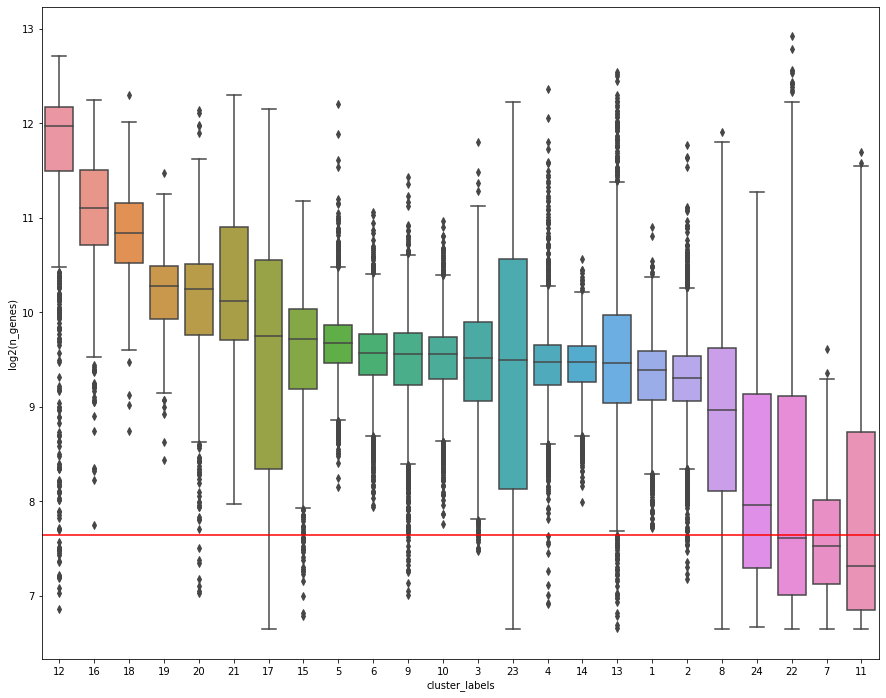

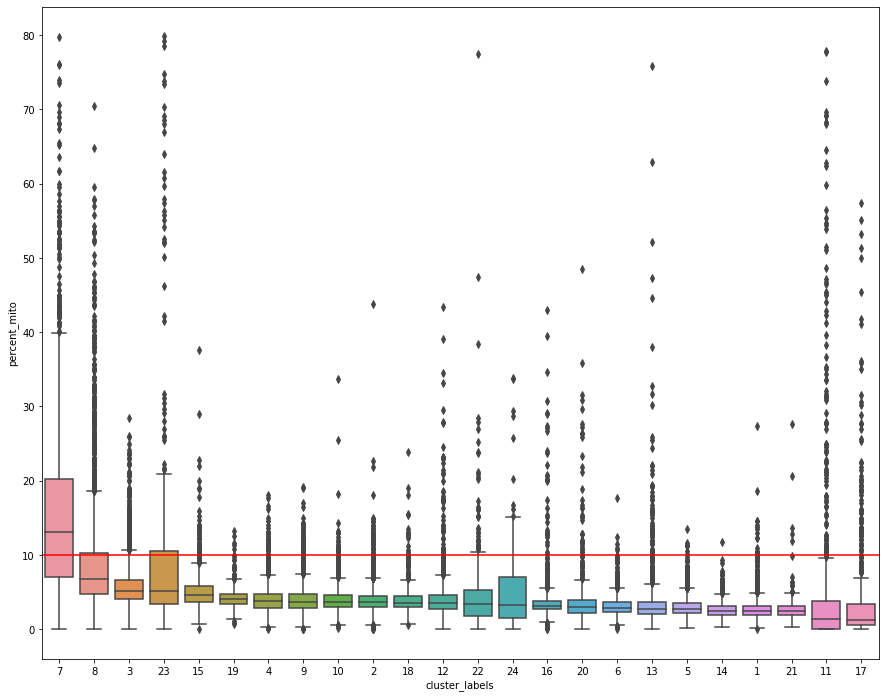

In [3]:
df_qc = pg.ddqc_metrics(data, return_df_qc=True)

In [4]:
data

MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 48210 x 25910
    Genome: GRCh38; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'percent_ribo', 'passed_qc'
    var: 'featureid'
    obsm: 
    varm: 
    uns: 'genome', 'modality'

If you want to customize the filtering you can use the following parameters:
- `res`: float - clustering resolution (default: 1.3)
- `method`: string - statistic on which the threshold would be calculated (default: "mad", available options "mad", "outlier")
- `threshold`: float - parameter for the selected method (default: 2)
- `basic_n_genes`: int - parameter for the initial QC n_genes filtering (default: 100)
- `basic_percent_mito`: float - parameter for the initial QC percent_mito filtering (default: 80)
- `mito_prefix`: string - gene prefix used to calculate percent_mito in a cell (default: "MT-")
- `ribo_prefix`: string - gene regular expression used to calculate percent_ribo in a cell (default: "^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA")
- `do_counts`: bool - whether to consider n_counts for ddqc (default: True)
- `do_genes`: bool - whether to consider n_genes for ddqc (default: True)
- `do_mito`: bool - whether to consider percent_mito for ddqc (default: True)
- `do_ribo`: bool - whether to consider percent_ribo for ddqc (default: False)
- `n_genes_lower_bound`: int - bound for lower n_genes cluster-level threshold (default: 200)
- `basic_percent_mito`: float - bound for upper percent_mito cluster-level threshold (default: 10)
- `random_state`: int - random seed for clustering results reproducibility (default: 29)
- `return_df_qc`: bool - whether to return a dataframe with the information about on what metric and what threshold the cell was removed for each removed cell. (default: False)

If you requested to return df_qc the function will return a pandas dataframe containing the following info for each cell:
- `cluster_labels`: cluster from initial clustering performed by ddqc
- `metric_passed_qc`: whether the cell passed ddqc for given metric
- `metric_lower_co` and `metric_upper_co`: lower and upper cuttofs for each metric on which ddqc was performed. If ddqc was not performed for upper or lower end of this metric this field will be `None`
- `passed_qc`: whether the cell passed overall ddqc
This information is useful if you want to understand based on which metric the cell was filtered out and what was the cutoff.

In [5]:
df_qc

cluster_labels n_counts_lower_co  \
barcodekey                                                            
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA              6         1359.2792   
MantonBM1_HiSeq_1-AAACCTGCACACTGCG              3         -464.3688   
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA              1          731.1666   
MantonBM1_HiSeq_1-AAACCTGCATAGACTC              4          729.4072   
MantonBM1_HiSeq_1-AAACCTGCATCGATGT             13         -335.4844   
...                                           ...               ...   
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT              1          731.1666   
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT              3         -464.3688   
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG              3         -464.3688   
MantonBM8_HiSeq_1-TTTGTCAGTTTACTCT             21        -1336.0876   
MantonBM8_HiSeq_1-TTTGTCATCACCACCT              7             1.698   

                                   n_counts_upper_co  n_counts  \
barcodekey                                                       
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA              None    3554.0   
MantonBM1_HiSeq_1-AAACCTGCACACTGCG              None    1740.0   
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA              None    2435.0   
MantonBM1_HiSeq_1-AAACCTGCATAGACTC              None    2913.0   
MantonBM1_HiSeq_1-AAACCTGCATCGATGT              None    5372.0   
...                                              ...       ...   
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT              None    1570.0   
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT              None    1367.0   
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG              None    3834.0   
MantonBM8_HiSeq_1-TTTGTCAGTTTACTCT              None    5982.0   
MantonBM8_HiSeq_1-TTTGTCATCACCACCT              None     472.0   

                                   n_counts_passed_qc n_genes_lower_co  \
barcodekey                                                               
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA               True              200   
MantonBM1_HiSeq_1-AAACCTGCACACTGCG               True         111.2732   
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA               True              200   
MantonBM1_HiSeq_1-AAACCTGCATAGACTC               True              200   
MantonBM1_HiSeq_1-AAACCTGCATCGATGT               True          77.3428   
...                                               ...              ...   
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT               True              200   
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT               True         111.2732   
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG               True         111.2732   
MantonBM8_HiSeq_1-TTTGTCAGTTTACTCT               True         -67.1496   
MantonBM8_HiSeq_1-TTTGTCATCACCACCT               True          26.8444   

                                   n_genes_upper_co  n_genes  \
barcodekey                                                     
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA             None    816.0   
MantonBM1_HiSeq_1-AAACCTGCACACTGCG             None    716.0   
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA             None    554.0   
MantonBM1_HiSeq_1-AAACCTGCATAGACTC             None    967.0   
MantonBM1_HiSeq_1-AAACCTGCATCGATGT             None   1704.0   
...                                             ...      ...   
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT             None    454.0   
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT             None    539.0   
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG             None   1117.0   
MantonBM8_HiSeq_1-TTTGTCAGTTTACTCT             None   1569.0   
MantonBM8_HiSeq_1-TTTGTCATCACCACCT             None    181.0   

                                   n_genes_passed_qc percent_mito_lower_co  \
barcodekey                                                                   
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA              True                  None   
MantonBM1_HiSeq_1-AAACCTGCACACTGCG              True                  None   
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA              True                  None   
MantonBM1_HiSeq_1-AAACCTGCATAGACTC              True              

Then you can generate different QC plots as described in pegasus tutorial. When you are done and want to proceed to downstream analysis, run the following command:

In [6]:
pg.filter_data(data)

2021-03-31 19:55:59,087 - pegasusio.qc_utils - INFO - After filtration, 45939 out of 48210 cell barcodes are kept in UnimodalData object GRCh38-rna.
2021-03-31 19:55:59,088 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 1.14s.
